In [2]:
%set_env OMP_NUM_THREADS=1

env: OMP_NUM_THREADS=1


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
import dedalus.public as d3
import os
import json
import logging
logger = logging.getLogger(__name__)
import shutil
import h5py
from glob import glob
import warnings
import scipy.special as special

## $\partial_t \phi = \nabla \cdot \left( \phi (1 - \phi) \nabla \dfrac{\delta F}{\delta \phi} \right)$

In [4]:
# for savefiles name
savefolder = "/Users/danny/Library/CloudStorage/GoogleDrive-dsseara@uchicago.edu/My Drive/uchicago/adaptation/schelling/2023-05-04_chfh"
shutil.rmtree(savefolder, ignore_errors=True)

# simulation parameters
L = 40
t_stop = 1000
npts = 64
Δt = 0.01
dealias = 3/2

# check stability criterion
Δx = L / npts
if Δt * Δx**(-4) > 1/8:
    warnings.warn("von Neumann stability not satisfied")

# Cahn-Hilliard Flory-Huggins parameter
χ = 1.0
ϕ0 = 0.25
δϕ = 0.05
Tc = 2 * χ * ϕ0 * (1 - 2 * ϕ0)
T = Tc * 0.9
κ = 0
δ = 0

# 1D bases
coord = d3.Coordinate('x')
dist = d3.Distributor(coord, dtype=np.float64)
xbasis = d3.RealFourier(coord, npts, bounds=(-L/2, L/2), dealias=dealias)

# fields
ϕA = dist.Field(name="phiA", bases=(xbasis))
ϕB = dist.Field(name="phiB", bases=(xbasis))

# problem
problem = d3.IVP([ϕA, ϕB], namespace=locals())

# substitutions
dx = lambda A: d3.Differentiate(A, coord)
μA = ϕA * (1 - ϕA - ϕB)
μB = ϕB * (1 - ϕA - ϕB)

### Cahn-Hilliard Flory Huggins ###

### ∂phi / ∂t = div(phi(1 - phi) grad µ) ###
problem.add_equation("dt(ϕA) - T * dx(dx(ϕA)) = dx(μA * dx(χ * (1 - 2 * ϕA)) + μA * (κ - δ) * dx(ϕB)) - dx(μA * dx(dx(dx(ϕA))))")
problem.add_equation("dt(ϕB) - T * dx(dx(ϕB)) = dx(μB * dx(χ * (1 - 2 * ϕB)) + μB * (κ + δ) * dx(ϕA)) - dx(μB * dx(dx(dx(ϕB))))")

### ∂phi / ∂t = div(phi grad µ) ###
# problem.add_equation("dt(ϕA) = dx(T * dx(ϕA) / (1 - ϕ) - 2 * χ * ϕA * dx(ϕA) - ϕA * dx(dx(dx(ϕA))))")
# problem.add_equation("dt(ϕB) = dx(T * dx(ϕB) / (1 - ϕ) - 2 * χ * ϕB * dx(ϕB) - ϕB * dx(dx(dx(ϕB))))")

### ∂phi / ∂t = div(grad µ) ###
# problem.add_equation("dt(ϕA) + 2 * χ * dx(dx(ϕA)) + dx(dx(dx(dx(ϕA)))) = T * dx(dx(ϕA) / (ϕA * (1 - ϕ)))")
# problem.add_equation("dt(ϕB) + 2 * χ * dx(dx(ϕB)) + dx(dx(dx(dx(ϕB)))) = T * dx(dx(ϕB) / (ϕB * (1 - ϕ)))")

#################

# solver and stopping
solver = problem.build_solver(d3.SBDF2)
solver.stop_sim_time = t_stop

# initial condition
x = dist.local_grid(xbasis)
ϕA["g"] = ϕ0 + δϕ * np.random.randn(len(x)) # np.sin(2 * np.pi * x / (L/2)) #  * np.random.randn(len(x))
ϕB["g"] = ϕ0 + δϕ * np.random.randn(len(x)) # np.sin(2 * np.pi * x / (L/2) + np.pi / 2) #  * np.random.randn(len(x))

# storage
# snapshots = solver.evaluator.add_file_handler(savefolder,
#                                               sim_dt=0.05,
#                                               max_writes=500)
# snapshots.add_task(phi, layout="g", name="phi")
t_list = []
ϕA_list = []
ϕB_list = []

# main loop
try:
    logger.info('Starting main loop...')
    while solver.proceed:
        if solver.iteration % 200 == 0:
            t_list.append(solver.sim_time)
            ϕAc = ϕA.copy()
            ϕBc = ϕB.copy()
            ϕAc.change_scales((dealias,))
            ϕBc.change_scales((dealias,))
            ϕA_list.append(ϕAc["g"])
            ϕB_list.append(ϕBc["g"])

        solver.step(Δt)

        if np.isnan(np.min(ϕA["g"])) or np.isnan(np.min(ϕB["g"])):
                raise RuntimeError("got NaNs. Ending main loop.")

        if solver.iteration % 10000 == 0:
            time_spent = solver.get_wall_time() - solver.start_time
            logger.info(rf"Iteration={solver.iteration}, sim time={solver.sim_time:0.2f} / {t_stop}, real Δt ={time_spent:0.2f} s")
except:
    logger.error("Exception raised, ending main loop.")
    raise
finally:
    solver.log_stats()

2023-07-05 14:12:57,370 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.0e+02/s
2023-07-05 14:12:57,374 __main__ 0/1 INFO :: Starting main loop...
2023-07-05 14:13:04,334 __main__ 0/1 INFO :: Iteration=10000, sim time=100.00 / 1000, real Δt =6.67 s
2023-07-05 14:13:10,939 __main__ 0/1 INFO :: Iteration=20000, sim time=200.00 / 1000, real Δt =13.27 s
2023-07-05 14:13:17,705 __main__ 0/1 INFO :: Iteration=30000, sim time=300.00 / 1000, real Δt =20.04 s
2023-07-05 14:13:24,363 __main__ 0/1 INFO :: Iteration=40000, sim time=400.00 / 1000, real Δt =26.70 s
2023-07-05 14:13:31,092 __main__ 0/1 INFO :: Iteration=50000, sim time=500.00 / 1000, real Δt =33.43 s
2023-07-05 14:13:37,914 __main__ 0/1 INFO :: Iteration=60000, sim time=600.00 / 1000, real Δt =40.25 s
2023-07-05 14:13:44,639 __main__ 0/1 INFO :: Iteration=70000, sim time=700.00 / 1000, real Δt =46.97 s
2023-07-05 14:13:51,375 __main__ 0/1 INFO :: Iteration=80000, sim time=800.00 / 1

TypeError: Dimensions of C (501, 96) are incompatible with X (64) and/or Y (501); see help(pcolormesh)

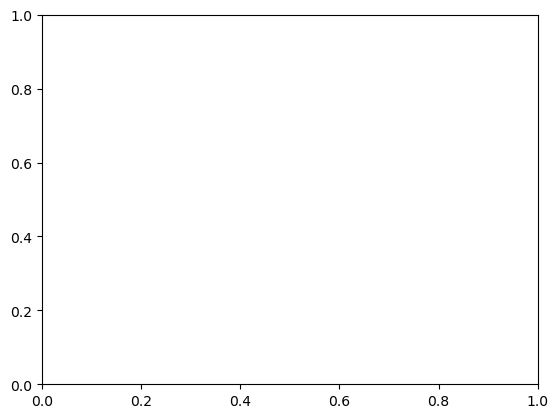

In [5]:
plt.pcolormesh(x, t_list, ϕB_list)

2023-07-05 14:18:45,193 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2023-07-05 14:18:45,194 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x300 -pix_fmt rgba -r 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /var/folders/n8/skcq750x2vdc2nch0nv470wh0000gn/T/tmp94qlcytu/temp.m4v


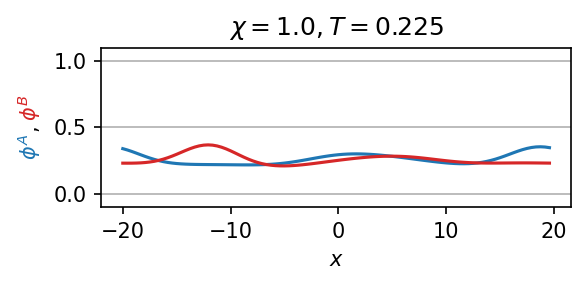

In [6]:
fig, ax = plt.subplots(dpi=150, figsize=(4, 2))
# initialize line
x = dist.local_grid(xbasis, scale=dealias)
lineA, = ax.plot(x, ϕA_list[0], color="C0", label=r"$\phi^A$")
lineB, = ax.plot(x, ϕB_list[0], color="C3", label=r"$\phi^B$")
# line, = ax.plot(x, ϕA_list[0] + ϕB_list[0], color="k")

ax.set(ylim=[-0.1, 1.1],
       xlabel=r"$x$",
       title=rf"$\chi = {χ}, T = {T}$")
ax.grid(axis="y")
# ax.legend()
ax.text(-30, 0.45, r"$\phi^A$", color="C0", rotation="vertical", va="top")
ax.text(-29.5, 0.5, ",", color="k", rotation="vertical")
ax.text(-30, 0.55, r"$\phi^B$", color="C3", rotation="vertical", va="bottom")
plt.tight_layout()
def init():
    return [lineA, lineB]

def animate(i):
    lineA.set_xdata(x) # line plot
    lineA.set_ydata(ϕA_list[i]) # line plot

    lineB.set_xdata(x) # line plot
    lineB.set_ydata(ϕB_list[i]) # line plot
    
    # line.set_xdata(x) # line plot
    # line.set_ydata(ϕA_list[i] + ϕB_list[i]) # line plot

    return [lineA, lineB]

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(ϕA_list), interval=40, blit=True)
# anim.save(os.path.join("/Users/danny/Library/CloudStorage/GoogleDrive-dsseara@uchicago.edu/My Drive/uchicago/adaptation/schelling/",
#                        rf"2023-05-12_2SpeciesCHFH_sync.mp4"))

HTML(anim.to_html5_video())


In [55]:
# entropy
S = np.array([- special.xlogy(ϕa, ϕa)
              - special.xlogy(ϕb, ϕb)
              - special.xlogy(1 - ϕa - ϕb, 1 - ϕa - ϕb)
              for ϕa, ϕb in zip(ϕA_list, ϕB_list)])

# potential function
uA = np.array([χ * ϕa * (1 - ϕa) for ϕa in ϕA_list])
uB = np.array([χ * ϕb * (1 - ϕb) for ϕb in ϕB_list])
u = uA + uB

# gradient
dx = np.diff(x)[0]
gradA = np.array([np.gradient(ϕa, dx) for ϕa in ϕA_list])
gradB = np.array([np.gradient(ϕb, dx) for ϕb in ϕB_list])
grad = (gradA**2 + gradB**2) / 2

lyapunov = -T * S + u - grad

(None, None)

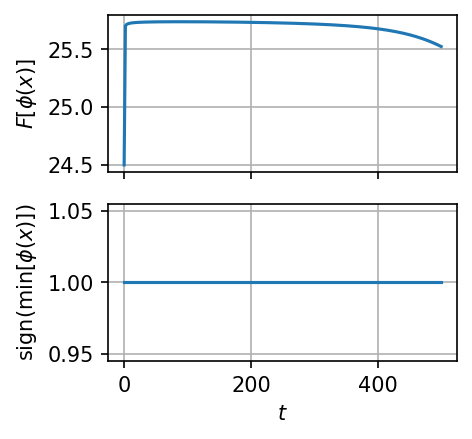

In [56]:
fig, ax = plt.subplots(2, 1, dpi=150, figsize=(3,3), sharex=True)
ax[0].plot(t_list, np.nansum(lyapunov, axis=1))
ax[1].plot(t_list, np.sign(np.min(ϕA_list, axis=1)))
ax[0].set(ylabel=r"$F[\phi(x)]$")
ax[1].set(xlabel=r"$t$", ylabel=r"$\mathrm{sign}(\mathrm{min}[\phi(x)])$")
ax[0].grid(), ax[1].grid()